<a href="https://colab.research.google.com/github/adenurchalisa/Automatic-Photo-Clustering-System-Optimization-HDBSCAN/blob/main/notebooks/9_UMAP_HDBSCAN_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 9: UMAP + HDBSCAN Pipeline

## Latar Belakang

HDBSCAN bekerja berdasarkan estimasi densitas lokal. Pada ruang berdimensi tinggi (512 dimensi dari InsightFace), estimasi densitas menjadi tidak akurat karena fenomena **curse of dimensionality** — jarak antar titik cenderung homogen sehingga HDBSCAN sulit membedakan mana region yang dense dan mana yang sparse.

**UMAP (Uniform Manifold Approximation and Projection)** mengurangi dimensi sambil mempertahankan struktur lokal *dan* global dari data. Berbeda dengan PCA yang linear, UMAP menggunakan Riemannian geometry dan algebraic topology sehingga mampu menangkap hubungan non-linear antar embedding.

Referensi: Allaoui et al. (2020) melaporkan peningkatan akurasi hingga **60%** saat UMAP digunakan sebagai preprocessing sebelum HDBSCAN.

## Mengapa `metric='cosine'` di UMAP?

InsightFace buffalo_l dilatih menggunakan **ArcFace loss**, yang secara eksplisit mengoptimasi angular margin antar kelas di embedding space. Artinya, hubungan semantik antar wajah lebih terepresentasi dalam sudut (angle) daripada jarak Euclidean. Dengan menggunakan `metric='cosine'` di UMAP, manifold yang dibangun lebih mencerminkan struktur asli dari ArcFace embedding space.

## Mengapa `min_dist=0.0`?

Parameter `min_dist` mengontrol seberapa padat UMAP boleh mengemas titik-titik yang saling berdekatan. Nilai `0.0` mengizinkan UMAP untuk memadat-madatkan cluster semaksimal mungkin, sehingga densitas lokal yang dibaca oleh HDBSCAN menjadi lebih kontras dan mudah dideteksi.

## Metrik Evaluasi Baru: Coverage Rate

Selain Silhouette Score, notebook ini memperkenalkan **Coverage Rate** sebagai metrik utama:

```
Coverage Rate = jumlah poin yang masuk cluster / total poin
```

Silhouette Score hanya dihitung pada poin yang **berhasil masuk cluster**, sehingga ia tidak sensitif terhadap noise ratio yang tinggi. Coverage Rate secara langsung mengukur seberapa banyak wajah dalam dataset yang berhasil dikelompokkan — metrik yang paling relevan untuk tujuan sistem dokumentasi foto ini.

---

## Cell 1 — Instalasi

Menginstal `umap-learn` (library UMAP) dan memverifikasi instalasi `hdbscan`.

In [1]:
!pip install umap-learn hdbscan -q
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12 -q

import importlib

def check_version(package_name, import_name=None):
    import_name = import_name or package_name
    try:
        mod = importlib.import_module(import_name)
        try:
            ver = mod.__version__
        except AttributeError:
            from importlib.metadata import version
            ver = version(package_name)
        print(f"   {package_name}: {ver} ✅")
    except Exception as e:
        print(f"   {package_name}: ❌ {e}")

print("="*50)
print("✅ VERIFIKASI INSTALASI")
print("="*50)
check_version('umap-learn', 'umap')
check_version('hdbscan')
check_version('cuml-cu12', 'cuml')
check_version('scikit-learn', 'sklearn')
check_version('numpy')
check_version('pandas')

✅ VERIFIKASI INSTALASI
   umap-learn: 0.5.11 ✅
   hdbscan: 0.8.41 ✅
   scikit-learn: 1.6.1 ✅
   numpy: 2.0.2 ✅
   pandas: 2.2.2 ✅


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


## Cell 2 — Imports & Konfigurasi

Semua path, hyperparameter grid, dan nilai baseline dari Eksperimen 1.5 dikentralisasi di class `Config` agar mudah diubah tanpa perlu menelusuri seluruh notebook.

**Search space UMAP:**
- `n_components` (target dimensi): 30, 50, 100
- `n_neighbors` (ukuran lingkungan lokal): 10, 15, 30

**Search space HDBSCAN:**
- `min_cluster_size`: 10, 15, 20
- `min_samples`: 20, 30, 50

Total: 3 × 3 × 3 × 3 = **81 eksperimen**.

In [2]:
import numpy as np
import pickle
import time
import os
import warnings
from collections import Counter
from datetime import datetime

import umap
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# ── GPU Backend ─────────────────────────────────────────────────────────────
try:
    from cuml.cluster import HDBSCAN as cuHDBSCAN
    from cuml.manifold import UMAP as cuUMAP
    import cupy as cp
    USE_GPU = True
    print("🚀 GPU backend: cuML aktif — UMAP & HDBSCAN berjalan di GPU")
except ImportError:
    USE_GPU = False
    print("⚠️  cuML tidak tersedia — fallback ke CPU (hdbscan + umap-learn)")
# ────────────────────────────────────────────────────────────────────────────


class Config:
    EMBEDDINGS_PATH = '/content/drive/MyDrive/OTW S.KOM/Embeddings/embeddings_data.pkl'
    RESULTS_DIR     = '/content/drive/MyDrive/OTW S.KOM/Results/'
    PLOTS_DIR       = '/content/drive/MyDrive/OTW S.KOM/Results/Plots/'

    BASELINE = {
        'name'          : 'Correlation (mcs=15, ms=70)',
        'silhouette'    : 0.4530,
        'n_clusters'    : 54,
        'noise_ratio'   : 0.438,
        'coverage_rate' : 0.562,
    }

    UMAP_N_COMPONENTS = [30, 50, 100]
    UMAP_N_NEIGHBORS  = [10, 15, 30]
    UMAP_METRIC       = 'cosine'
    UMAP_MIN_DIST     = 0.0
    UMAP_RANDOM_STATE = 42

    HDBSCAN_MCS    = [10, 15, 20]
    HDBSCAN_MS     = [20, 30, 50]
    HDBSCAN_METHOD = 'eom'


print("="*60)
print("✅ CONFIG LOADED")
print("="*60)

print(f"\n📊 BASELINE (Eksperimen 1.5 — Best):")
for k, v in Config.BASELINE.items():
    if isinstance(v, float) and v < 10:
        print(f"   {k:<16}: {v:.4f}" if v > 1 else f"   {k:<16}: {v:.1%}")
    else:
        print(f"   {k:<16}: {v}")

total = (len(Config.UMAP_N_COMPONENTS) *
         len(Config.UMAP_N_NEIGHBORS)  *
         len(Config.HDBSCAN_MCS)       *
         len(Config.HDBSCAN_MS))
print(f"\n🔢 Total Eksperimen Grid Search: {total}")
print(f"⚡ Backend aktif              : {'GPU (cuML)' if USE_GPU else 'CPU (hdbscan + umap-learn)'}")

✅ CONFIG LOADED

📊 BASELINE (Eksperimen 1.5 — Best):
   name            : Correlation (mcs=15, ms=70)
   silhouette      : 45.3%
   n_clusters      : 54
   noise_ratio     : 43.8%
   coverage_rate   : 56.2%

🔢 Total Eksperimen Grid Search: 81


## Cell 3 — Load Data

Memuat embeddings yang sudah diextract menggunakan InsightFace buffalo_l dari `feature_extraction.ipynb`. Embeddings di-cast ke `float32` untuk efisiensi memori karena UMAP tidak memerlukan presisi `float64`.

In [3]:
from google.colab import drive

print("="*60)
print("📁 LOAD DATA")
print("="*60)

if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print("✅ Google Drive sudah ter-mount")

os.makedirs(Config.RESULTS_DIR, exist_ok=True)
os.makedirs(Config.PLOTS_DIR, exist_ok=True)

print("\n⏳ Loading embeddings...")
with open(Config.EMBEDDINGS_PATH, 'rb') as f:
    data = pickle.load(f)

embeddings = np.array(data['embeddings']).astype('float32')
metadata   = data['metadata']

print(f"\n✅ Data loaded!")
print(f"   Shape  : {embeddings.shape}")
print(f"   Dtype  : {embeddings.dtype}")
print(f"   Samples: {len(embeddings):,} face embeddings")
print(f"   Dims   : {embeddings.shape[1]} (InsightFace buffalo_l)")

📁 LOAD DATA
Mounted at /content/drive

⏳ Loading embeddings...

✅ Data loaded!
   Shape  : (12715, 512)
   Dtype  : float32
   Samples: 12,715 face embeddings
   Dims   : 512 (InsightFace buffalo_l)


## Cell 4 — Fungsi Evaluasi

Fungsi `evaluate_clustering()` menghitung semua metrik yang diperlukan sekaligus.

**Coverage Rate** adalah metrik utama baru. Ini dihitung dari semua data, bukan hanya yang masuk cluster, sehingga mencerminkan performa sistem secara keseluruhan.

**Calinski-Harabasz Index** mengukur rasio dispersi antar-cluster terhadap dispersi dalam cluster. Semakin tinggi nilainya, semakin compact dan well-separated cluster yang terbentuk.

**Catatan implementasi:** `silhouette_score` dihitung di ruang UMAP-reduced (bukan 512-dim asli) karena clustering juga dilakukan di ruang tersebut. Ini konsisten dan valid secara metodologis.

In [4]:
def evaluate_clustering(embeddings_reduced, labels):
    n_total     = len(labels)
    mask        = labels != -1
    n_clustered = int(mask.sum())
    unique_lbls = set(labels[mask]) if n_clustered > 0 else set()
    n_clusters  = len(unique_lbls)

    result = {
        'n_clusters'        : n_clusters,
        'n_noise'           : int((labels == -1).sum()),
        'noise_ratio'       : float((labels == -1).sum() / n_total),
        'coverage_rate'     : float(n_clustered / n_total),
        'silhouette'        : None,
        'calinski_harabasz' : None,
        'dbi'               : None,
    }

    if n_clustered > 10 and n_clusters >= 2:
        emb_c = embeddings_reduced[mask]
        lbl_c = labels[mask]
        result['silhouette']        = float(silhouette_score(emb_c, lbl_c))
        result['calinski_harabasz'] = float(calinski_harabasz_score(emb_c, lbl_c))
        result['dbi']               = float(davies_bouldin_score(emb_c, lbl_c))

    return result


print("✅ evaluate_clustering() didefinisikan")
print()
print("Metrik yang dihitung:")
print("  coverage_rate     → proporsi data yang berhasil dikelompokkan [UTAMA]")
print("  noise_ratio       → proporsi data yang menjadi noise")
print("  n_clusters        → jumlah cluster yang terbentuk")
print("  silhouette        → kekompakan dan separabilitas cluster [-1, 1]")
print("  calinski_harabasz → dispersi antar vs dalam cluster [lebih tinggi = lebih baik]")
print("  dbi               → Davies-Bouldin Index [lebih rendah = lebih baik]")

✅ evaluate_clustering() didefinisikan

Metrik yang dihitung:
  coverage_rate     → proporsi data yang berhasil dikelompokkan [UTAMA]
  noise_ratio       → proporsi data yang menjadi noise
  n_clusters        → jumlah cluster yang terbentuk
  silhouette        → kekompakan dan separabilitas cluster [-1, 1]
  calinski_harabasz → dispersi antar vs dalam cluster [lebih tinggi = lebih baik]
  dbi               → Davies-Bouldin Index [lebih rendah = lebih baik]


## Cell 5 — Grid Search UMAP + HDBSCAN

Strategi grid search: untuk setiap konfigurasi UMAP, embeddings 512-dim direduksi ke ruang berdimensi lebih rendah. Hasil reduksi ini kemudian digunakan oleh HDBSCAN untuk setiap kombinasi hyperparameter.

**Efisiensi:** Setiap konfigurasi UMAP (kombinasi `n_components` dan `n_neighbors`) dijalankan sekali, lalu hasilnya digunakan untuk semua kombinasi HDBSCAN yang relevan. UMAP biasanya memakan waktu 30–90 detik per konfigurasi, sedangkan HDBSCAN jauh lebih cepat di ruang berdimensi rendah.

**Output disimpan per-result** termasuk `reduced_embeddings` dan `labels` untuk memungkinkan visualisasi dan analisis lanjutan tanpa perlu menjalankan ulang UMAP.

In [5]:
print("="*70)
print("🔬 GRID SEARCH: UMAP + HDBSCAN")
print("="*70)
print(f"\n📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Dataset: {embeddings.shape[0]:,} × {embeddings.shape[1]} dims")
print(f"   Target dims    : {Config.UMAP_N_COMPONENTS}")
print(f"   n_neighbors    : {Config.UMAP_N_NEIGHBORS}")
print(f"   UMAP metric    : {Config.UMAP_METRIC}")
print(f"   HDBSCAN mcs    : {Config.HDBSCAN_MCS}")
print(f"   HDBSCAN ms     : {Config.HDBSCAN_MS}")
print(f"   Backend        : {'GPU (cuML)' if USE_GPU else 'CPU'}")

all_results  = []
exp_counter  = 0
start_global = time.time()

for n_comp in Config.UMAP_N_COMPONENTS:
    for n_neigh in Config.UMAP_N_NEIGHBORS:

        print(f"\n{'─'*60}")
        print(f"⏳ UMAP  →  n_components={n_comp}, n_neighbors={n_neigh}, metric=cosine, min_dist=0.0")

        t_umap = time.time()
        if USE_GPU:
            reducer = cuUMAP(
                n_components = n_comp,
                n_neighbors  = n_neigh,
                metric       = Config.UMAP_METRIC,
                min_dist     = Config.UMAP_MIN_DIST,
                random_state = Config.UMAP_RANDOM_STATE,
            )
        else:
            reducer = umap.UMAP(
                n_components = n_comp,
                n_neighbors  = n_neigh,
                metric       = Config.UMAP_METRIC,
                min_dist     = Config.UMAP_MIN_DIST,
                random_state = Config.UMAP_RANDOM_STATE,
                verbose      = False,
            )
        emb_reduced = np.asarray(reducer.fit_transform(embeddings))
        umap_time   = time.time() - t_umap

        print(f"   ✅ Shape: {embeddings.shape} → {emb_reduced.shape}  ({umap_time:.1f}s)")
        print(f"   {'mcs':>4} {'ms':>4} | {'clusters':>8} {'coverage':>9} {'noise':>7} {'silhouette':>11} {'calinski':>10}")
        print(f"   {'─'*4} {'─'*4} | {'─'*8} {'─'*9} {'─'*7} {'─'*11} {'─'*10}")

        for mcs in Config.HDBSCAN_MCS:
            for ms in Config.HDBSCAN_MS:
                t_hdb = time.time()
                if USE_GPU:
                    clusterer = cuHDBSCAN(
                        min_cluster_size         = mcs,
                        min_samples              = ms,
                        cluster_selection_method = Config.HDBSCAN_METHOD,
                    )
                else:
                    clusterer = hdbscan.HDBSCAN(
                        min_cluster_size         = mcs,
                        min_samples              = ms,
                        cluster_selection_method = Config.HDBSCAN_METHOD,
                    )
                labels   = np.asarray(clusterer.fit_predict(emb_reduced))
                hdb_time = time.time() - t_hdb
                metrics  = evaluate_clustering(emb_reduced, labels)

                result = {
                    'n_components'     : n_comp,
                    'n_neighbors'      : n_neigh,
                    'min_cluster_size' : mcs,
                    'min_samples'      : ms,
                    'umap_time'        : umap_time,
                    'hdbscan_time'     : hdb_time,
                    'reduced_embeddings': emb_reduced.copy(),
                    'labels'           : labels.copy(),
                    **metrics,
                }
                all_results.append(result)
                exp_counter += 1

                sil_str = f"{metrics['silhouette']:.4f}" if metrics['silhouette'] else "   N/A"
                cal_str = f"{metrics['calinski_harabasz']:.1f}" if metrics['calinski_harabasz'] else "N/A"
                print(f"   {mcs:>4} {ms:>4} | "
                      f"{metrics['n_clusters']:>8} "
                      f"{metrics['coverage_rate']:>9.1%} "
                      f"{metrics['noise_ratio']:>7.1%} "
                      f"{sil_str:>11} "
                      f"{cal_str:>10}")

total_time = time.time() - start_global
print(f"\n{'='*70}")
print(f"✅ Grid search selesai! {exp_counter} eksperimen dalam {total_time:.1f}s")

🔬 GRID SEARCH: UMAP + HDBSCAN

📅 2026-03-01 07:16:23
   Dataset: 12,715 × 512 dims
   Target dims    : [30, 50, 100]
   n_neighbors    : [10, 15, 30]
   UMAP metric    : cosine
   HDBSCAN mcs    : [10, 15, 20]
   HDBSCAN ms     : [20, 30, 50]

────────────────────────────────────────────────────────────
⏳ UMAP  →  n_components=30, n_neighbors=10, metric=cosine, min_dist=0.0
   ✅ Shape: (12715, 512) → (12715, 30)  (51.2s)
    mcs   ms | clusters  coverage   noise  silhouette   calinski
   ──── ──── | ──────── ───────── ─────── ─────────── ──────────
     10   20 |      105     97.1%    2.9%      0.8892    42564.5
     10   30 |       85     98.1%    1.9%      0.8989    29760.3
     10   50 |       70     95.9%    4.1%      0.8773     9421.5
     15   20 |       98     98.1%    1.9%      0.8957    45728.0
     15   30 |       85     98.1%    1.9%      0.8989    29760.3
     15   50 |       70     95.9%    4.1%      0.8773     9421.5
     20   20 |       96     98.6%    1.4%      0.9007  

## Cell 6 — Analisis Hasil & Pemilihan Konfigurasi Terbaik

Hasil dari seluruh grid search dirangkum dalam DataFrame pandas untuk kemudahan analisis.

Dua kandidat konfigurasi terbaik dipilih:

1. **Best by Coverage Rate** — konfigurasi yang berhasil mengelompokkan paling banyak wajah. Ini adalah prioritas utama karena relevan langsung dengan use case sistem dokumentasi.

2. **Best by Silhouette Score** — konfigurasi dengan cluster paling compact dan well-separated. Ini penting untuk akurasi pengelompokan.

Keduanya kemudian dibandingkan dengan baseline (Exp 1.5) untuk menentukan apakah UMAP memberikan peningkatan yang berarti.

In [8]:
df_cols = [
    'n_components', 'n_neighbors', 'min_cluster_size', 'min_samples',
    'n_clusters', 'coverage_rate', 'noise_ratio',
    'silhouette', 'calinski_harabasz', 'dbi',
]

df = pd.DataFrame([
    {c: r[c] for c in df_cols} for r in all_results
])

df_valid = df.dropna(subset=['silhouette']).copy()

idx_coverage   = df_valid['coverage_rate'].idxmax()
idx_silhouette = df_valid['silhouette'].idxmax()

best_coverage   = df_valid.loc[idx_coverage]
best_silhouette = df_valid.loc[idx_silhouette]

print("="*70)
print("📊 TOP 15 HASIL (diurutkan: Coverage Rate ↓)")
print("="*70)

top15 = df_valid.sort_values('coverage_rate', ascending=False).head(15)
fmt = {
    'coverage_rate'     : lambda x: f'{x:.1%}',
    'noise_ratio'       : lambda x: f'{x:.1%}',
    'silhouette'        : lambda x: f'{x:.4f}',
    'calinski_harabasz' : lambda x: f'{x:.1f}',
    'dbi'               : lambda x: f'{x:.4f}',
}

print(top15.to_string(index=False, formatters=fmt))

print()
print("="*70)
print("🏆 KONFIGURASI TERBAIK")
print("="*70)

def print_config(label, row):
    print(f"\n  {label}")
    print(f"  {'─'*50}")
    print(f"  n_components    : {int(row['n_components'])}")
    print(f"  n_neighbors     : {int(row['n_neighbors'])}")
    print(f"  min_cluster_size: {int(row['min_cluster_size'])}")
    print(f"  min_samples     : {int(row['min_samples'])}")
    print(f"  Clusters        : {int(row['n_clusters'])}")
    print(f"  Coverage Rate   : {row['coverage_rate']:.1%}  (baseline: {Config.BASELINE['coverage_rate']:.1%})")
    print(f"  Noise Ratio     : {row['noise_ratio']:.1%}  (baseline: {Config.BASELINE['noise_ratio']:.1%})")
    print(f"  Silhouette      : {row['silhouette']:.4f}  (baseline: {Config.BASELINE['silhouette']:.4f})")
    if row['calinski_harabasz']:
        print(f"  Calinski-Harabasz: {row['calinski_harabasz']:.1f}")
    if row['dbi']:
        print(f"  DBI              : {row['dbi']:.4f}")

print_config("🥇 Best by Coverage Rate", best_coverage)
print_config("🥈 Best by Silhouette Score", best_silhouette)

cov_delta = best_coverage['coverage_rate'] - Config.BASELINE['coverage_rate']
sil_delta = best_silhouette['silhouette']  - Config.BASELINE['silhouette']

print(f"\n  Delta Coverage Rate  (best vs baseline): {cov_delta:+.1%}")
print(f"  Delta Silhouette     (best vs baseline): {sil_delta:+.4f}")

📊 TOP 15 HASIL (diurutkan: Coverage Rate ↓)
 n_components  n_neighbors  min_cluster_size  min_samples  n_clusters coverage_rate noise_ratio silhouette calinski_harabasz    dbi
           30           30                20           20          95         99.3%        0.7%     0.9041           53306.1 0.1685
           50           15                20           20          95         99.3%        0.7%     0.9043           23020.0 0.3249
           30           30                15           20          96         99.2%        0.8%     0.8996           52916.0 0.1720
           30           30                10           20          96         99.2%        0.8%     0.8996           52916.0 0.1720
           50           15                15           20          97         99.1%        0.9%     0.9027           22439.7 0.3252
           30           15                10           20          99         99.0%        1.0%     0.8924           29146.6 0.2240
           30           15      

## Cell 7 — Visualisasi

Untuk visualisasi, UMAP dijalankan sekali lagi dengan `n_components=2` menggunakan parameter terbaik yang ditemukan. Proyeksi 2D ini **hanya untuk visualisasi** dan tidak mempengaruhi hasil clustering.

Plot yang dibuat:
1. **Scatter plot cluster** — setiap wajah diplot di ruang 2D UMAP, diwarnai sesuai cluster. Noise ditampilkan sebagai titik abu-abu kecil.
2. **Coverage Rate comparison** — bar chart membandingkan Coverage Rate antar konfigurasi terbaik vs baseline.
3. **Silhouette comparison** — bar chart serupa untuk Silhouette Score.
4. **Distribusi ukuran cluster** — histogram jumlah anggota per cluster untuk melihat apakah cluster terdistribusi merata atau didominasi beberapa cluster besar.


⏳ Membuat UMAP 2D untuk visualisasi...
   (n_neighbors=30, cosine, min_dist=0.0)
   ✅ Done

💾 Plot disimpan: /content/drive/MyDrive/OTW S.KOM/Results/Plots/notebook9_umap_hdbscan_results.png


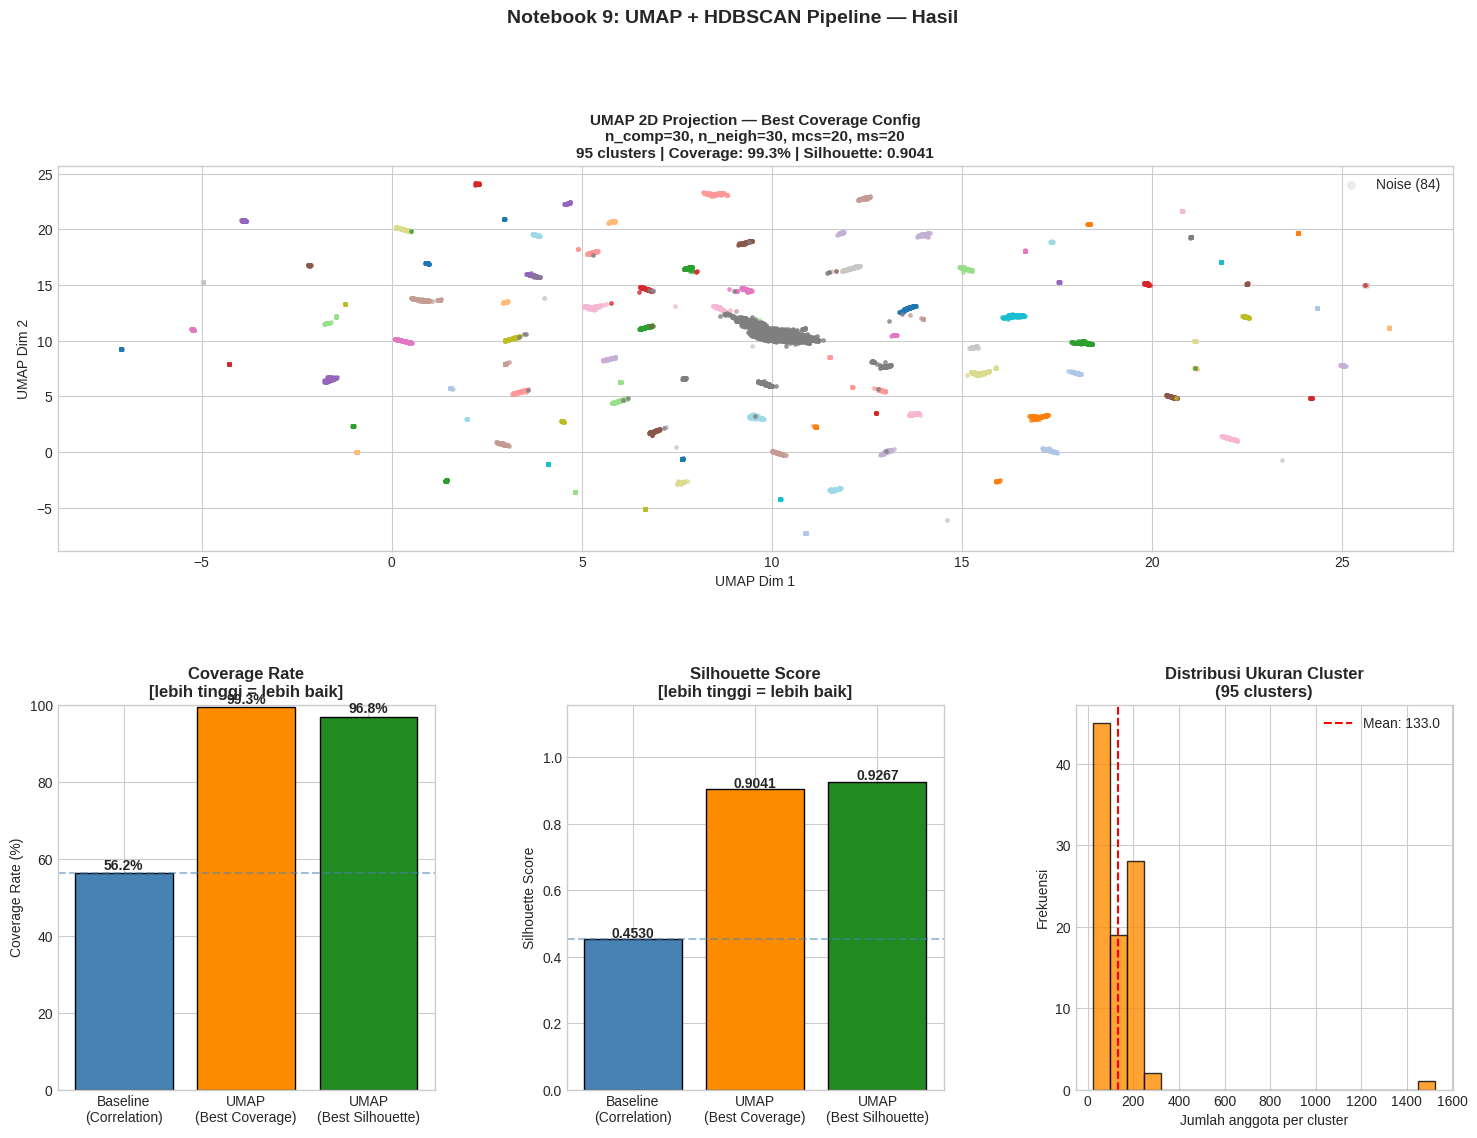

In [9]:
best_idx    = df_valid['coverage_rate'].idxmax()
best_result = all_results[df_valid.index.get_loc(best_idx)]

best_n_comp  = int(best_coverage['n_components'])
best_n_neigh = int(best_coverage['n_neighbors'])

print(f"\n⏳ Membuat UMAP 2D untuk visualisasi...")
print(f"   (n_neighbors={best_n_neigh}, cosine, min_dist=0.0)")
print(f"   Backend: {'GPU (cuML)' if USE_GPU else 'CPU'}")

if USE_GPU:
    reducer_2d = cuUMAP(
        n_components = 2,
        n_neighbors  = best_n_neigh,
        metric       = Config.UMAP_METRIC,
        min_dist     = Config.UMAP_MIN_DIST,
        random_state = Config.UMAP_RANDOM_STATE,
    )
else:
    reducer_2d = umap.UMAP(
        n_components = 2,
        n_neighbors  = best_n_neigh,
        metric       = Config.UMAP_METRIC,
        min_dist     = Config.UMAP_MIN_DIST,
        random_state = Config.UMAP_RANDOM_STATE,
        verbose      = False,
    )
emb_2d = np.asarray(reducer_2d.fit_transform(embeddings))
print("   ✅ Done")

labels_best = best_result['labels']
mask_noise  = labels_best == -1
mask_clustered = ~mask_noise
n_cls = int(best_coverage['n_clusters'])

cmap = plt.colormaps.get_cmap('tab20')

fig = plt.figure(figsize=(18, 12))
gs  = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.35)

ax_scatter = fig.add_subplot(gs[0, :])
ax_cover   = fig.add_subplot(gs[1, 0])
ax_sil     = fig.add_subplot(gs[1, 1])
ax_hist    = fig.add_subplot(gs[1, 2])

ax_scatter.scatter(
    emb_2d[mask_noise, 0], emb_2d[mask_noise, 1],
    c='lightgrey', s=3, alpha=0.4, label=f'Noise ({mask_noise.sum():,})',
    zorder=1,
)

unique_labels = sorted(set(labels_best[mask_clustered]))
for i, lbl in enumerate(unique_labels):
    mask_lbl = labels_best == lbl
    color = cmap(i % 20)
    ax_scatter.scatter(
        emb_2d[mask_lbl, 0], emb_2d[mask_lbl, 1],
        c=[color], s=6, alpha=0.7, zorder=2,
    )

ax_scatter.set_title(
    f'UMAP 2D Projection — Best Coverage Config\n'
    f'n_comp={best_n_comp}, n_neigh={best_n_neigh}, '
    f'mcs={int(best_coverage["min_cluster_size"])}, '
    f'ms={int(best_coverage["min_samples"])}\n'
    f'{n_cls} clusters | Coverage: {best_coverage["coverage_rate"]:.1%} | '
    f'Silhouette: {best_coverage["silhouette"]:.4f}',
    fontsize=11, fontweight='bold',
)
ax_scatter.set_xlabel('UMAP Dim 1')
ax_scatter.set_ylabel('UMAP Dim 2')
ax_scatter.legend(loc='upper right', markerscale=3)

labels_compare = ['Baseline\n(Correlation)', 'UMAP\n(Best Coverage)', 'UMAP\n(Best Silhouette)']
colors_compare = ['steelblue', 'darkorange', 'forestgreen']

cover_values = [
    Config.BASELINE['coverage_rate'],
    best_coverage['coverage_rate'],
    best_silhouette['coverage_rate'],
]
sil_values = [
    Config.BASELINE['silhouette'],
    best_coverage['silhouette'],
    best_silhouette['silhouette'],
]

bars = ax_cover.bar(labels_compare, [v*100 for v in cover_values], color=colors_compare, edgecolor='black')
ax_cover.set_ylabel('Coverage Rate (%)')
ax_cover.set_title('Coverage Rate\n[lebih tinggi = lebih baik]', fontweight='bold')
ax_cover.set_ylim(0, 100)
ax_cover.axhline(Config.BASELINE['coverage_rate'] * 100, color='steelblue', linestyle='--', alpha=0.5)
for bar, val in zip(bars, cover_values):
    ax_cover.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                  f'{val:.1%}', ha='center', fontsize=10, fontweight='bold')

bars2 = ax_sil.bar(labels_compare, sil_values, color=colors_compare, edgecolor='black')
ax_sil.set_ylabel('Silhouette Score')
ax_sil.set_title('Silhouette Score\n[lebih tinggi = lebih baik]', fontweight='bold')
ax_sil.set_ylim(0, max(sil_values) * 1.25)
ax_sil.axhline(Config.BASELINE['silhouette'], color='steelblue', linestyle='--', alpha=0.5)
for bar, val in zip(bars2, sil_values):
    ax_sil.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{val:.4f}', ha='center', fontsize=10, fontweight='bold')

cluster_sizes = Counter(labels_best[mask_clustered])
sizes = list(cluster_sizes.values())
ax_hist.hist(sizes, bins=20, color='darkorange', edgecolor='black', alpha=0.8)
ax_hist.set_xlabel('Jumlah anggota per cluster')
ax_hist.set_ylabel('Frekuensi')
ax_hist.set_title(f'Distribusi Ukuran Cluster\n({n_cls} clusters)', fontweight='bold')
ax_hist.axvline(np.mean(sizes), color='red', linestyle='--', label=f'Mean: {np.mean(sizes):.1f}')
ax_hist.legend()

fig.suptitle('Notebook 9: UMAP + HDBSCAN Pipeline — Hasil', fontsize=14, fontweight='bold', y=1.01)

plt.tight_layout()
plot_path = f"{Config.PLOTS_DIR}notebook9_umap_hdbscan_results.png"
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"\n💾 Plot disimpan: {plot_path}")
plt.show()

## Cell 8 — Summary & Simpan Hasil

Semua hasil grid search dan konfigurasi terbaik disimpan ke file `.pkl` dan `.csv` untuk digunakan di notebook selanjutnya.

File yang disimpan:
- `notebook9_umap_results.pkl` — full results termasuk labels dan reduced embeddings
- `notebook9_umap_results_table.csv` — tabel metrik seluruh eksperimen untuk referensi

**Kesimpulan** dicetak sebagai perbandingan langsung antara konfigurasi UMAP terbaik dan baseline Eksperimen 1.5.

In [10]:
print("="*70)
print("📋 NOTEBOOK 9 — SUMMARY")
print("="*70)

print(f"""
┌─────────────────────────────────────────────────────────────────────────┐
│                  PERBANDINGAN: BASELINE vs UMAP + HDBSCAN               │
├───────────────────────────┬─────────────────┬───────────────────────────┤
│ Metrik                    │ Baseline        │ UMAP Best Coverage        │
│                           │ Correlation     │ (cosine, min_dist=0.0)    │
├───────────────────────────┼─────────────────┼───────────────────────────┤
│ Coverage Rate [↑]         │ {Config.BASELINE['coverage_rate']:.1%}           │ {best_coverage['coverage_rate']:.1%}                     │
│ Noise Ratio   [↓]         │ {Config.BASELINE['noise_ratio']:.1%}           │ {best_coverage['noise_ratio']:.1%}                     │
│ Silhouette    [↑]         │ {Config.BASELINE['silhouette']:.4f}          │ {best_coverage['silhouette']:.4f}                    │
│ Clusters                  │ {Config.BASELINE['n_clusters']}              │ {int(best_coverage['n_clusters'])}                       │
│ n_components              │ 512 (raw)       │ {int(best_coverage['n_components'])}                        │
│ n_neighbors               │ —               │ {int(best_coverage['n_neighbors'])}                        │
│ min_cluster_size          │ 15              │ {int(best_coverage['min_cluster_size'])}                        │
│ min_samples               │ 70              │ {int(best_coverage['min_samples'])}                        │
└───────────────────────────┴─────────────────┴───────────────────────────┘
""")

cov_improvement = best_coverage['coverage_rate'] - Config.BASELINE['coverage_rate']
sil_change      = best_coverage['silhouette']    - Config.BASELINE['silhouette']

print(f"  Delta Coverage Rate : {cov_improvement:+.1%}")
print(f"  Delta Silhouette    : {sil_change:+.4f}")

if cov_improvement > 0:
    print(f"\n  ✅ UMAP BERHASIL meningkatkan Coverage Rate sebesar {cov_improvement:.1%}")
    print(f"     Artinya {cov_improvement * len(embeddings):.0f} wajah tambahan berhasil dikelompokkan.")
else:
    print(f"\n  ⚠️  UMAP TIDAK meningkatkan Coverage Rate.")
    print(f"     Pertimbangkan untuk mengubah parameter UMAP atau mencoba PCA.")

save_data = {
    'timestamp'        : datetime.now().isoformat(),
    'notebook'         : 'Notebook 9: UMAP + HDBSCAN Pipeline',
    'baseline'         : Config.BASELINE,
    'best_by_coverage' : {
        'n_components'     : int(best_coverage['n_components']),
        'n_neighbors'      : int(best_coverage['n_neighbors']),
        'min_cluster_size' : int(best_coverage['min_cluster_size']),
        'min_samples'      : int(best_coverage['min_samples']),
        'n_clusters'       : int(best_coverage['n_clusters']),
        'coverage_rate'    : float(best_coverage['coverage_rate']),
        'noise_ratio'      : float(best_coverage['noise_ratio']),
        'silhouette'       : float(best_coverage['silhouette']),
        'calinski_harabasz': float(best_coverage['calinski_harabasz']) if best_coverage['calinski_harabasz'] else None,
        'dbi'              : float(best_coverage['dbi']) if best_coverage['dbi'] else None,
        'labels'           : best_result['labels'],
        'reduced_embeddings': best_result['reduced_embeddings'],
    },
    'best_by_silhouette': {
        'n_components'     : int(best_silhouette['n_components']),
        'n_neighbors'      : int(best_silhouette['n_neighbors']),
        'min_cluster_size' : int(best_silhouette['min_cluster_size']),
        'min_samples'      : int(best_silhouette['min_samples']),
        'n_clusters'       : int(best_silhouette['n_clusters']),
        'coverage_rate'    : float(best_silhouette['coverage_rate']),
        'noise_ratio'      : float(best_silhouette['noise_ratio']),
        'silhouette'       : float(best_silhouette['silhouette']),
    },
    'all_results_df'   : df.to_dict('records'),
    'umap_2d_projection': emb_2d,
}

pkl_path = f"{Config.RESULTS_DIR}notebook9_umap_results.pkl"
csv_path = f"{Config.RESULTS_DIR}notebook9_umap_results_table.csv"

with open(pkl_path, 'wb') as f:
    pickle.dump(save_data, f)

df.sort_values('coverage_rate', ascending=False).to_csv(csv_path, index=False)

print(f"\n💾 Disimpan:")
print(f"   {pkl_path}")
print(f"   {csv_path}")

print("\n" + "="*70)
print("🎯 NEXT: Notebook 10 — Angular Distance + Soft Clustering")
print("="*70)

📋 NOTEBOOK 9 — SUMMARY

┌─────────────────────────────────────────────────────────────────────────┐
│                  PERBANDINGAN: BASELINE vs UMAP + HDBSCAN               │
├───────────────────────────┬─────────────────┬───────────────────────────┤
│ Metrik                    │ Baseline        │ UMAP Best Coverage        │
│                           │ Correlation     │ (cosine, min_dist=0.0)    │
├───────────────────────────┼─────────────────┼───────────────────────────┤
│ Coverage Rate [↑]         │ 56.2%           │ 99.3%                     │
│ Noise Ratio   [↓]         │ 43.8%           │ 0.7%                     │
│ Silhouette    [↑]         │ 0.4530          │ 0.9041                    │
│ Clusters                  │ 54              │ 95                       │
│ n_components              │ 512 (raw)       │ 30                        │
│ n_neighbors               │ —               │ 30                        │
│ min_cluster_size          │ 15              │ 20                